# Optimizing Physical Systems

To learn about optimization, we'll focus on the simple example of a projectile, like a cannonball being fired from a cannon.

Assuming the cannonball comes out of the barrel at the same speed every time, the launch angle will decide the trajectory as seen below.

![Projectile trajectories](pics/projectile_trajectories.png)

By looking at the picture you can see that 80° is the trajectory that sends the cannonball the highest, and 45° the trajectory that sends the cannonball the furthest. Our goal is to systematically explore the range of possible launch angles to be able to obtain the trajectory that optimizes the launch between 0° and 90°.

To do this, we will build a simulator for the cannonball using a Python function `landing_position` that takes a launch angle as input, then runs Euler's method (as seen [Simulating moving objects](../08_simulating-moving-objects/08_simulating-moving-objects.ipynb)) and returns the range of the cannonball at that angle.

With that function in place, we can think about the problem of finding the launch angle that maximizes the range. We can find that angle by either:
- making a graph of the range vs. launch angle and look for the largest value using our simulator
- find a formula for the range $ r(\theta) $ of the projectile as a function of the launch angle $ \theta $.

Both approaches should produce identical results.

In particular, when using the formula we will be able to take its derivative. The derivative of the landing position with respect to the launch angle will tell us how much increase in the range we'll get for small increases in the launch angle.

At some angle, we will start getting diminishing returns (increasing the launch angle will cause the range to decrease) which means we'd have passed our optimal value. Before this, the derivative of $ r(\theta) $ will be zero, and the value of $ \theta $ where the derivative is zero happens to be at the maximum value.

Afterwards, we will run a more challenging 3D simulation in which we will be able to control the upward angle of the cannon, as well as the lateral direction. This might have an impact in real scenarios where the terrain varies around the cannon.

In this case, we will build a function $ r(\theta, \phi) $ that will output the final landing position of the projectile. We will look for the pair $ (\theta, \phi) $ that maximizes the range of the cannon. For this case we will use an important optimization technique called the *gradient ascent*.

We'll write a Python function `gradient_ascent` that will take as input a function to optimize, along with a pair of starting inputs, and will use the gradient to find higher and higher values until it reaches the optimal value.

## Testing a projectile simulation

In this section we will build a simulator that computes the flight path of the cannonball.

It will be implemented via a function called `trajectory` that will take the launch angle, as well as other few parameters that we may want to control, and will return the possitions of the cannonball over time until it collides with earth. To build the simulation we will rely on the Euler's method.

As a reminder, Euler's method lets you simulate motion by advancing through time in small increments (such as 0.01 seconds). At each moment, we'll know the position of the cannonball, as well as it's derivatives that give us the velocity and acceleration respectively.

The velocity and acceleration will let us approximate the change in position to the next moment. The process will be repeated until the cannonball hits the ground. In each iteration we will be storing the $ x $ and $ y $ positions, which we will return once the `trajectory` function completes.

Finally, we'll write functions that take the results from the `trajectory` function and will give us metrics such as `landing_position`, `hang_time`, and `max_height`. Those will be the values subject of being optimized.

### Building a simulation with Euler's method

For our simulation, we call the horizontal direction $ x $ and the vertical direction $ z $ (so that we don't have to rename them when we tackle the 3D simulation).

The angle of the cannon will be $ theta $ and the velocity of the cannon will be $ \vec{v} $.

![Cannon variables](pics/cannon-variables.png)

The speed, $ v $, of a moving object is the magnitude of its velocity. Thus, $ v = |\vec{v}| $.

Using trigonometry, we can say:

$
v_x = |v| \cdot cos(\theta) \\
v_y = |v| \cdot sin(\theta)
$

We should also include the height at which the cannon is placed as a parameter.

With all that information in place, we can write the implementation of the `trajectory` function:

In [1]:
from math import cos, sin, pi

def trajectory(theta_deg, speed=20, height=0, dt=0.01, g=-9.81):
    vx = speed * cos(pi * theta_deg / 180)
    vz = speed * sin(pi * theta_deg / 180)
    t, x, z = 0, 0, height
    ts, xs, zs = [t], [x], [z]
    while z >= 0:
        t += dt
        vz += g * dt
        x += vx * dt
        z += vz * dt
        ts.append(t)
        xs.append(xs)
        zs.append(zs)
    return ts, xs, zs

We can start using this function to get trajectories for different angles, speed and heights.

A `plot_trajectories` function will also be useful to visualize those trajectories

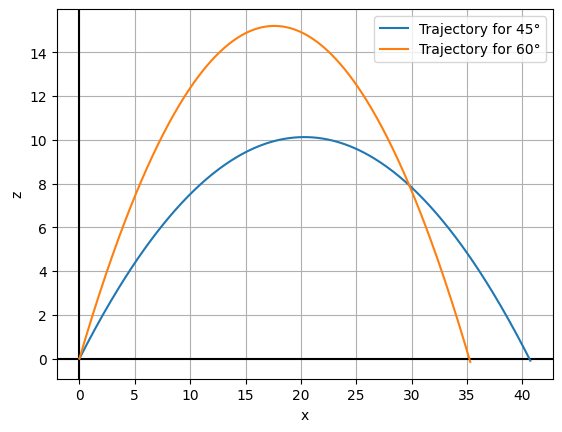

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from math import cos, sin, pi

def trajectory(theta_deg, speed=20, height=0, dt=0.01, g=-9.81):
    vx = speed * cos(pi * theta_deg / 180)
    vz = speed * sin(pi * theta_deg / 180)
    t, x, z = 0, 0, height
    ts, xs, zs = [t], [x], [z]
    while z >= 0:
        t += dt
        vz += g * dt
        x += vx * dt
        z += vz * dt
        ts.append(t)
        xs.append(x)
        zs.append(z)

    label = f"Trajectory for {theta_deg}°"
    if speed != 20:
        label += f" and speed {speed}"
    if height != 0:
        label += f" and height {height}"

    return ts, xs, zs, label

ts, xs, zs, label = trajectory(45)

def plot_trajectories(*trajectories):
    fig, ax = plt.subplots()
    ax.grid(True)
    ax.set_xlabel("x")
    ax.set_ylabel("z")

    ax.axhline(y=0, color="k")
    ax.axvline(x=0, color="k")

    for _, xs, zs, label in trajectories:
        ax.plot(xs, zs, label=label)

    ax.legend()
    plt.show()

plot_trajectories(
    trajectory(45),
    trajectory(60),
    )





We see that the 45° launch angle produces a greater range and that the 60° launch angle produces a greater maximum height.

### Measuring properties of the trajectory

While it's useful to keep the raw output of the trajectory (e.g., to plot it) sometime we'll want to focus on a specific metric.

For instance, we might want to get the range of the projectile (which is the last x position) before the cannonball hits the ground.

In [ ]:
def landing_position(traj):
    """
    returns the last x position of a trajectory before
    the projectile hits the ground
    """
    return traj[1][-1]

Some other interesting metrics are the *hanging time* (how long the projectile stays in the air) and the maximum height:

In [ ]:
def hang_time(traj):
    """
    returns the time the projectile is in the air
    """
    return traj[0][-1]

def max_height(traj):
    """
    returns the maximum height of the projectile
    """
    return max(traj[2])

To find the optimal value for any of these metrics, we need to explore how the parameters (namely, the launch angle, but could also be the speed, height) affect them.

### Exploring different launch angles

The `trajectory` function takes a launch angle and produces the full time and position data for the cannonball over its flight.

The function `landing_position` takes this data and produces a single number.

By combining these two together, we get a function that gives us the landing position given the launch angle, assuming all other properties of the simulation constant.

One way to visualize that combined function that measures the effect of the launch angle on the landing position is to make a plot of the resulting landing position for several different values of the launch angle.

The following plot is a scatter plot that lets you visualize that combined function with angles ranging from 0° to 90° in steps of 5°.

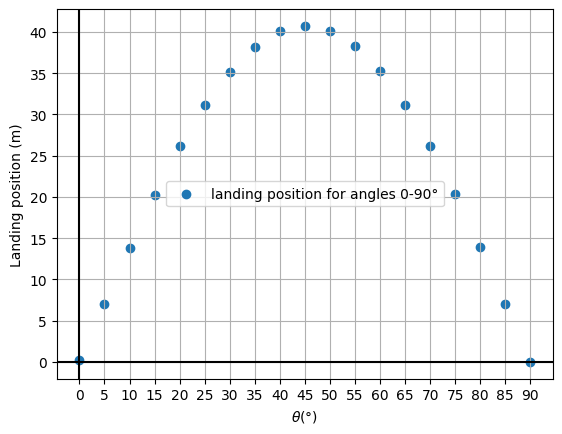

In [4]:
import matplotlib.pyplot as plt
from math import cos, sin, pi

def trajectory(theta_deg, speed=20, height=0, dt=0.01, g=-9.81):
    vx = speed * cos(pi * theta_deg / 180)
    vz = speed * sin(pi * theta_deg / 180)
    t, x, z = 0, 0, height
    ts, xs, zs = [t], [x], [z]
    while z >= 0:
        t += dt
        vz += g * dt
        x += vx * dt
        z += vz * dt
        ts.append(t)
        xs.append(x)
        zs.append(z)

    label = f"Trajectory for {theta_deg}°"
    if speed != 20:
        label += f" and speed {speed}"
    if height != 0:
        label += f" and height {height}"

    return ts, xs, zs, label

def landing_position(traj):
    """
    returns the last x position of a trajectory before
    the projectile hits the ground
    """
    return traj[1][-1]

angles = range(0, 95, 5)
landing_positions = [landing_position(trajectory(angle)) for angle in angles]


fig, ax = plt.subplots()
ax.grid(True)
ax.set_xticks(range(0, 95, 5))
ax.set_xlabel(r"$ \theta (°)$")
ax.set_ylabel("Landing position (m)")

ax.axhline(y=0, color="k")
ax.axvline(x=0, color="k")

ax.scatter(angles, landing_positions, label="landing position for angles 0-90°")

ax.legend()
plt.show()



From the plot we can see the maximum seems to be at or around 45°.

We can get the value from the combined function:

In [5]:
from math import cos, sin, pi

def trajectory(theta_deg, speed=20, height=0, dt=0.01, g=-9.81):
    vx = speed * cos(pi * theta_deg / 180)
    vz = speed * sin(pi * theta_deg / 180)
    t, x, z = 0, 0, height
    ts, xs, zs = [t], [x], [z]
    while z >= 0:
        t += dt
        vz += g * dt
        x += vx * dt
        z += vz * dt
        ts.append(t)
        xs.append(x)
        zs.append(z)

    label = f"Trajectory for {theta_deg}°"
    if speed != 20:
        label += f" and speed {speed}"
    if height != 0:
        label += f" and height {height}"

    return ts, xs, zs, label

def landing_position(traj):
    """
    returns the last x position of a trajectory before
    the projectile hits the ground
    """
    return traj[1][-1]

angles = range(0, 95, 5)
landing_positions = [landing_position(trajectory(angle)) for angle in angles]

print(f"Furthest landing position = {max(landing_positions)}m")


Furthest landing position = 40.72935059634507m


If we didn't have the plot, we could get the angle that maximizes the landing position with a little bit of Python:

In [9]:
from math import cos, sin, pi

def trajectory(theta_deg, speed=20, height=0, dt=0.01, g=-9.81):
    vx = speed * cos(pi * theta_deg / 180)
    vz = speed * sin(pi * theta_deg / 180)
    t, x, z = 0, 0, height
    ts, xs, zs = [t], [x], [z]
    while z >= 0:
        t += dt
        vz += g * dt
        x += vx * dt
        z += vz * dt
        ts.append(t)
        xs.append(x)
        zs.append(z)

    label = f"Trajectory for {theta_deg}°"
    if speed != 20:
        label += f" and speed {speed}"
    if height != 0:
        label += f" and height {height}"

    return ts, xs, zs, label

def landing_position(traj):
    """
    returns the last x position of a trajectory before
    the projectile hits the ground
    """
    return traj[1][-1]

angles = range(0, 95, 5)
landing_positions = [landing_position(trajectory(angle)) for angle in angles]

print(f"Angle for furthest landing position = {angles[landing_positions.index(max(landing_positions))]}° ({max(landing_positions)}m)")

Angle for furthest landing position = 45° (40.72935059634507m)


And we've used 5° as the angle step, but we can use a smaller angle to confirm the maximum seems to be exactly at 45°:

In [14]:
import numpy as np
from math import cos, sin, pi

def trajectory(theta_deg, speed=20, height=0, dt=0.01, g=-9.81):
    vx = speed * cos(pi * theta_deg / 180)
    vz = speed * sin(pi * theta_deg / 180)
    t, x, z = 0, 0, height
    ts, xs, zs = [t], [x], [z]
    while z >= 0:
        t += dt
        vz += g * dt
        x += vx * dt
        z += vz * dt
        ts.append(t)
        xs.append(x)
        zs.append(z)

    label = f"Trajectory for {theta_deg}°"
    if speed != 20:
        label += f" and speed {speed}"
    if height != 0:
        label += f" and height {height}"

    return ts, xs, zs, label

def landing_position(traj):
    """
    returns the last x position of a trajectory before
    the projectile hits the ground
    """
    return traj[1][-1]

angles = np.arange(0, 95, 0.01)
landing_positions = [landing_position(trajectory(angle)) for angle in angles]

print(f"Furthest landing position = {max(landing_positions)}m")
print(f"Angle for furthest landing position = {angles[landing_positions.index(max(landing_positions))]}°")


Furthest landing position = 40.77197993239255m
Angle for furthest landing position = 44.94°


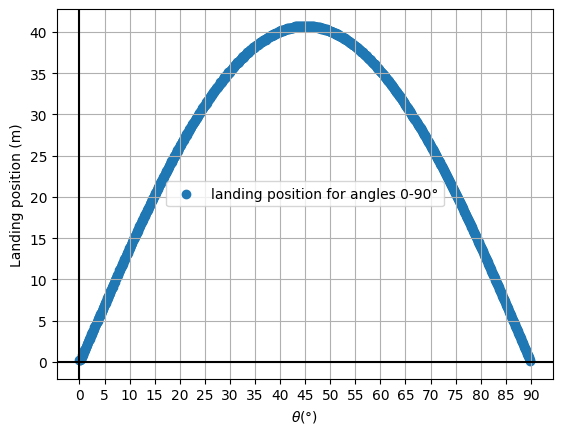

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from math import cos, sin, pi

def trajectory(theta_deg, speed=20, height=0, dt=0.01, g=-9.81):
    vx = speed * cos(pi * theta_deg / 180)
    vz = speed * sin(pi * theta_deg / 180)
    t, x, z = 0, 0, height
    ts, xs, zs = [t], [x], [z]
    while z >= 0:
        t += dt
        vz += g * dt
        x += vx * dt
        z += vz * dt
        ts.append(t)
        xs.append(x)
        zs.append(z)

    label = f"Trajectory for {theta_deg}°"
    if speed != 20:
        label += f" and speed {speed}"
    if height != 0:
        label += f" and height {height}"

    return ts, xs, zs, label

def landing_position(traj):
    """
    returns the last x position of a trajectory before
    the projectile hits the ground
    """
    return traj[1][-1]

angles = np.arange(0, 90, 0.1)
landing_positions = [landing_position(trajectory(angle)) for angle in angles]


fig, ax = plt.subplots()
ax.grid(True)
ax.set_xticks(range(0, 95, 5))
ax.set_xlabel(r"$ \theta (°)$")
ax.set_ylabel("Landing position (m)")

ax.axhline(y=0, color="k")
ax.axvline(x=0, color="k")

ax.scatter(angles, landing_positions, label="landing position for angles 0-90°")

ax.legend()
plt.show()



### Exercises

How far does the cannonball go when fired at an angle of 50° from an initial height of zero? How about if it is fired at an angle of 130°?

In order to solve those questions we just need to use our `landing_position` function:

In [1]:
from math import sin, cos, pi

def trajectory(theta_deg, speed=20, height=0, dt=0.01, g=-9.81):
    vx = speed * cos(pi * theta_deg / 180)
    vz = speed * sin(pi * theta_deg / 180)
    t, x, z = 0, 0, height
    ts, xs, zs = [t], [x], [z]
    while z >= 0:
        t += dt
        vz += g * dt
        x += vx * dt
        z += vz * dt
        ts.append(t)
        xs.append(x)
        zs.append(z)

    label = f"Trajectory for {theta_deg}°"
    if speed != 20:
        label += f" and speed {speed}"
    if height != 0:
        label += f" and height {height}"

    return ts, xs, zs, label

def landing_position(traj):
    """
    returns the last x position of a trajectory before
    the projectile hits the ground
    """
    return traj[1][-1]

landing_pos_50 = landing_position(trajectory(50))
landing_pos_130 = landing_position(trajectory(130))

print(f"Landing position for 50° = {landing_pos_50}m")
print(f"Landing position for 130° = {landing_pos_130}m")

Landing position for 50° = 40.10994684444007m
Landing position for 130° = -40.10994684444007m


Note that they travel the same distance (in absolute value) because 130° and 50° have the same inclination over the x- and x+ axis (respectively).

### Exercise

Enhance the `plot_trajectories` function to draw a large dot on the trajectory graph at each passing second so we can see the passing of time on the plot.

To implement what the exercise asks, we just need to add a scatter plot on top of the graph. Because we just want to draw one dot per second, we need to discard the intermediate values.

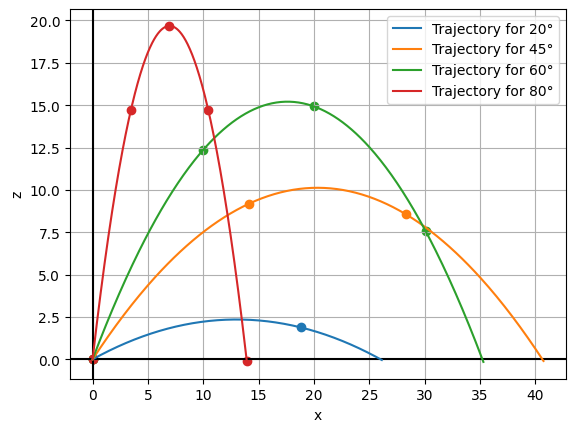

In [4]:
import matplotlib.pyplot as plt
from math import cos, sin, pi, floor

def trajectory(theta_deg, speed=20, height=0, dt=0.01, g=-9.81):
    vx = speed * cos(pi * theta_deg / 180)
    vz = speed * sin(pi * theta_deg / 180)
    t, x, z = 0, 0, height
    ts, xs, zs = [t], [x], [z]
    while z >= 0:
        t += dt
        vz += g * dt
        x += vx * dt
        z += vz * dt
        ts.append(t)
        xs.append(x)
        zs.append(z)

    label = f"Trajectory for {theta_deg}°"
    if speed != 20:
        label += f" and speed {speed}"
    if height != 0:
        label += f" and height {height}"

    return ts, xs, zs, label

def plot_trajectories(*trajectories):
    fig, ax = plt.subplots()
    ax.grid(True)
    ax.set_xlabel("x")
    ax.set_ylabel("z")

    ax.axhline(y=0, color="k")
    ax.axvline(x=0, color="k")

    for ts, xs, zs, label in trajectories:
        ax.plot(xs, zs, label=label)
        ts_seconds = [ts[0]]
        zs_seconds = [zs[0]]
        xs_seconds = [xs[0]]
        second = 1
        for i in range(0, len(ts)):
            if ts[i] >= second:
                ts_seconds.append(ts[i])
                zs_seconds.append(zs[i])
                xs_seconds.append(xs[i])
                second += 1
        ax.scatter(xs_seconds, zs_seconds)

    ax.legend()
    plt.show()

plot_trajectories(
    trajectory(20),
    trajectory(45),
    trajectory(60),
    trajectory(80),
    )

The book proposes a slightly cleaner implementation, along the same lines as the one above. 

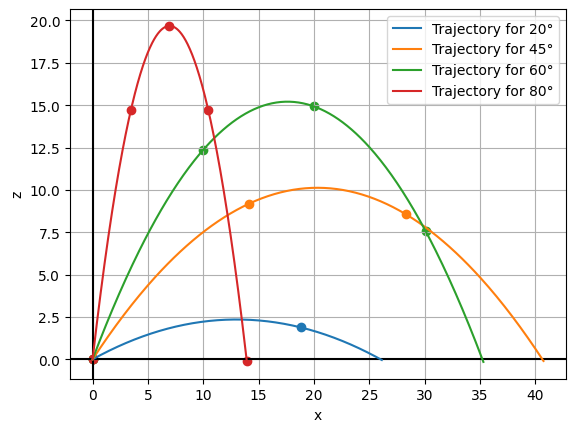

In [7]:
import matplotlib.pyplot as plt
from math import cos, sin, pi, floor

def trajectory(theta_deg, speed=20, height=0, dt=0.01, g=-9.81):
    vx = speed * cos(pi * theta_deg / 180)
    vz = speed * sin(pi * theta_deg / 180)
    t, x, z = 0, 0, height
    ts, xs, zs = [t], [x], [z]
    while z >= 0:
        t += dt
        vz += g * dt
        x += vx * dt
        z += vz * dt
        ts.append(t)
        xs.append(x)
        zs.append(z)

    label = f"Trajectory for {theta_deg}°"
    if speed != 20:
        label += f" and speed {speed}"
    if height != 0:
        label += f" and height {height}"

    return ts, xs, zs, label

def plot_trajectories(*trajectories, show_seconds=False):
    fig, ax = plt.subplots()
    ax.grid(True)
    ax.set_xlabel("x")
    ax.set_ylabel("z")

    ax.axhline(y=0, color="k")
    ax.axvline(x=0, color="k")

    for ts, xs, zs, label in trajectories:
        ax.plot(xs, zs, label=label)

        if show_seconds:
            second_indices = []
            second_mark = 0
            for i, t in enumerate(ts):
                if t >= second_mark:
                    second_indices.append(i)
                    second_mark += 1
            ax.scatter(
                [xs[i] for i in second_indices],
                [zs[i] for i in second_indices],
            )

    ax.legend()
    plt.show()

plot_trajectories(
    trajectory(20),
    trajectory(45),
    trajectory(60),
    trajectory(80),
    show_seconds=True,
    )

### Exercise

Make a scatter plot of hang time versus angle for angles between 0° and 180°? Which launch angle produces the maximum hang time?

We had already defined the functions for the trajectory, and hang time, therefore, it is very easy to just use those to compute the hang time as a function of the angle:

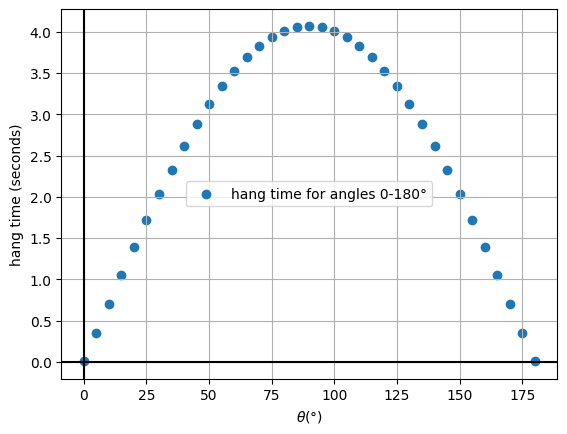

In [24]:
import matplotlib.pyplot as plt
from math import cos, sin, pi

def trajectory(theta_deg, speed=20, height=0, dt=0.01, g=-9.81):
    vx = speed * cos(pi * theta_deg / 180)
    vz = speed * sin(pi * theta_deg / 180)
    t, x, z = 0, 0, height
    ts, xs, zs = [t], [x], [z]
    while z >= 0:
        t += dt
        vz += g * dt
        x += vx * dt
        z += vz * dt
        ts.append(t)
        xs.append(x)
        zs.append(z)

    label = f"Trajectory for {theta_deg}°"
    if speed != 20:
        label += f" and speed {speed}"
    if height != 0:
        label += f" and height {height}"

    return ts, xs, zs, label

def hang_time(traj):
    """
    returns the time the projectile is in the air
    """
    return traj[0][-1]

angles = range(0, 181, 5)

fig, ax = plt.subplots()
ax.grid(True)
ax.set_xlabel("$ \\theta (°) $")
ax.set_ylabel("hang time (seconds)")

ax.axhline(y=0, color="k")
ax.axvline(x=0, color="k")
ax.set_xticks(range(0, 190, 25))

ax.scatter(angles, [hang_time(trajectory(theta_deg)) for theta_deg in angles], label="hang time for angles 0-180°")

ax.legend()
plt.show()


Having a look at the plot we can say that the launch angle that produces the maximum hang time is 90°. 

The data in the plot is also consistent with the previous exercise (e.g., 80° is 4 seconds, 20° is 1.x seconds, etc.)

We can also inspect the trajectory raw data to find the exact value:

In [15]:
from math import cos, sin, pi, floor

def trajectory(theta_deg, speed=20, height=0, dt=0.01, g=-9.81):
    vx = speed * cos(pi * theta_deg / 180)
    vz = speed * sin(pi * theta_deg / 180)
    t, x, z = 0, 0, height
    ts, xs, zs = [t], [x], [z]
    while z >= 0:
        t += dt
        vz += g * dt
        x += vx * dt
        z += vz * dt
        ts.append(t)
        xs.append(x)
        zs.append(z)

    label = f"Trajectory for {theta_deg}°"
    if speed != 20:
        label += f" and speed {speed}"
    if height != 0:
        label += f" and height {height}"

    return ts, xs, zs, label

def hang_time(traj):
    """
    returns the time the projectile is in the air
    """
    return traj[0][-1]

angles = range(0, 181)
hang_times = [hang_time(trajectory(angle)) for angle in angles]

print(f"Maximum hang time = {max(hang_times)}s")

max_hang_time = -1
for angle, hang_time in enumerate(hang_times):
    if hang_time >= max_hang_time:
        max_hang_time = hang_time
        max_angle = angle
    else:
        print(f"At angle {angle}° the hang time started decreasing")
        break
print(f"max hang time = {max_hang_time}s at {max_angle}°")


Maximum hang time = 4.069999999999958s
At angle 94° the hang time started decreasing
max hang time = 4.069999999999958s at 93°


Because of floating point arithmetics, we see that the maximum is at 93°, when it should be at 90°.

### Exercise

Write a function `plot_trajectory_metric` that plots the result of any metric we want over a given set of thetha $ \theta $ values.

For instance,

```python
plot_trajectory_metric(landing_position, [10, 20, 30])
```

must make a scatter plot of landing positions versus launch angle for the launch angles 10°, 20°, and 30°.

As a bonus, pass the keyword arguments from `plot_trajectory_metric` to the internal calls of the `trajectory` function, so that you can rerun the test with a different simulation parameter.

For instance, you should be able to use:

```python
plot_trajectory_metric(landing_position, [10, 20, 30], height=10)
```

to make a scatter plot of landing positions versus launch angle with simulated 10-meter initial launch height.

For this exercise, we use the [`cannonbalsim`](../../02_mini-projects/29-cannonball-simulation/) module kept in the mini-projects.

Let's first make sure it's correctly loaded:

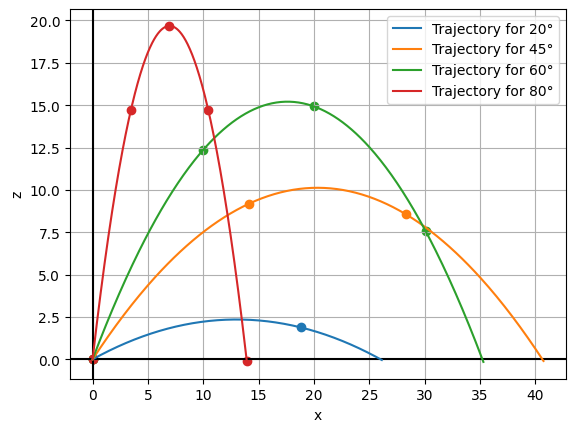

In [1]:
from cannonballsim import plot_trajectories, trajectory

plot_trajectories(
    trajectory(20),
    trajectory(45),
    trajectory(60),
    trajectory(80),
    show_seconds=True,
    )

We've seen in the previous exercises how to plot a particular metric, such as the hang time vs. the angle:

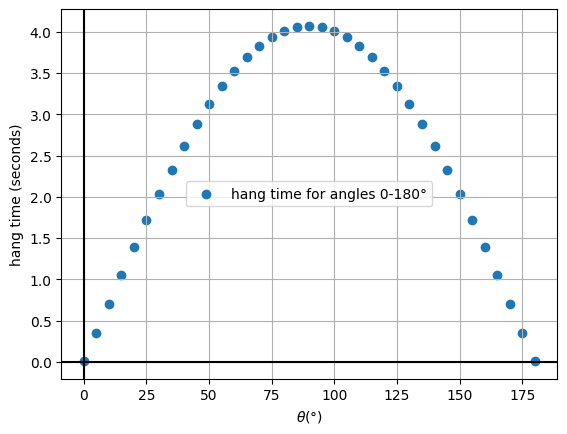

In [2]:
from cannonballsim import trajectory, hang_time
import matplotlib.pyplot as plt

angles = range(0, 181, 5)

fig, ax = plt.subplots()
ax.grid(True)
ax.set_xlabel("$ \\theta (°) $")
ax.set_ylabel("hang time (seconds)")

ax.axhline(y=0, color="k")
ax.axvline(x=0, color="k")
ax.set_xticks(range(0, 190, 25))

ax.scatter(angles, [hang_time(trajectory(theta_deg)) for theta_deg in angles], label="hang time for angles 0-180°")

ax.legend()
plt.show()


Thus, the only thing that we need to do is generalize the approach, so that the `plot_trajectory_metric` receives the metric function, and the sequence of angles to consider:

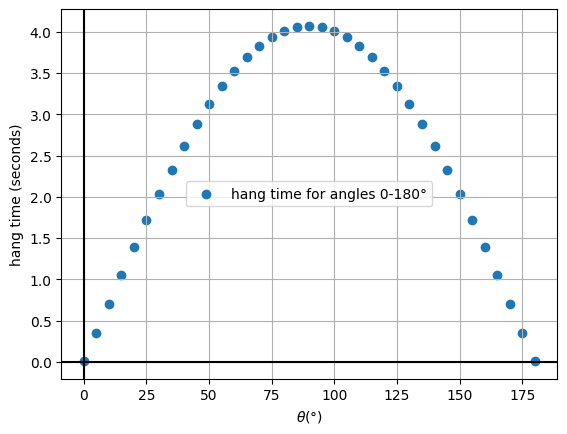

In [4]:
from cannonballsim import trajectory, hang_time
import matplotlib.pyplot as plt

def plot_trajectory_metric(metric, angles_deg, plot_label, metric_label):

    fig, ax = plt.subplots()
    ax.grid(True)
    ax.set_xlabel("$ \\theta (°) $")
    ax.set_ylabel(metric_label)

    ax.axhline(y=0, color="k")
    ax.axvline(x=0, color="k")

    ax.scatter(angles, [metric(trajectory(theta_deg)) for theta_deg in angles_deg], label=plot_label)

    ax.legend()
    plt.show()

plot_trajectory_metric(hang_time, range(0, 181, 5), plot_label="hang time for angles 0-180°", metric_label="hang time (seconds)")


To wrap it up, the function should be smart enough to also consider the initial values that can be passed to the `trajectory` function:

```python
def trajectory(
    theta_deg: float,
    speed: float = 20,
    height: float = 0,
    dt: float = 0.01,
    g: float = -9.81,
)
```

We'll use `**kwargs**` so that we don't have to define the parameters individually.

Let's first make sure it works without parameters:

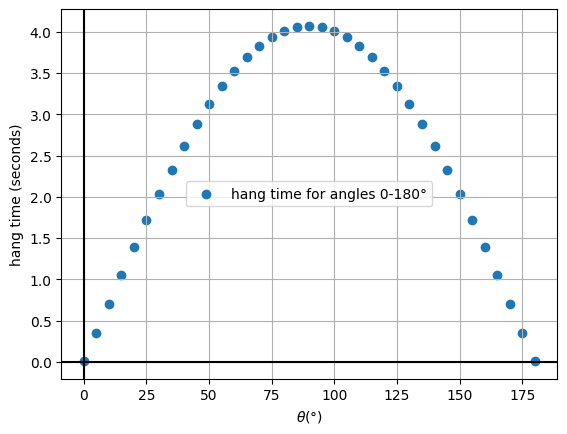

In [6]:
from cannonballsim import trajectory, hang_time
import matplotlib.pyplot as plt

def plot_trajectory_metric(metric, angles_deg, plot_label, metric_label, **kwargs):

    fig, ax = plt.subplots()
    ax.grid(True)
    ax.set_xlabel("$ \\theta (°) $")
    ax.set_ylabel(metric_label)

    ax.axhline(y=0, color="k")
    ax.axvline(x=0, color="k")

    ax.scatter(angles, [metric(trajectory(theta_deg, **kwargs)) for theta_deg in angles_deg], label=plot_label)

    ax.legend()
    plt.show()

plot_trajectory_metric(hang_time, range(0, 181, 5), plot_label="hang time for angles 0-180°", metric_label="hang time (seconds)")


And now we can test it passing some initial parameter, such as `height`:

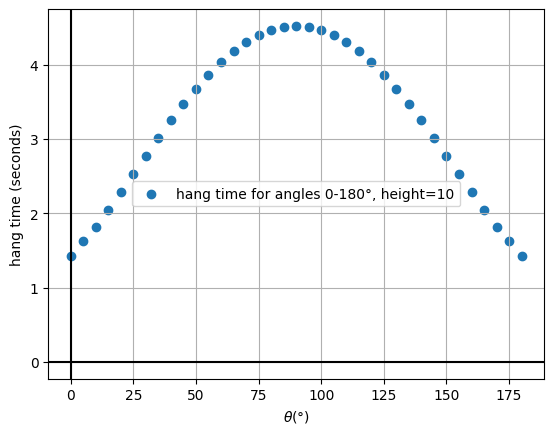

In [7]:
from cannonballsim import trajectory, hang_time
import matplotlib.pyplot as plt

def plot_trajectory_metric(metric, angles_deg, plot_label, metric_label, **kwargs):

    fig, ax = plt.subplots()
    ax.grid(True)
    ax.set_xlabel("$ \\theta (°) $")
    ax.set_ylabel(metric_label)

    ax.axhline(y=0, color="k")
    ax.axvline(x=0, color="k")

    ax.scatter(angles, [metric(trajectory(theta_deg, **kwargs)) for theta_deg in angles_deg], label=plot_label)

    ax.legend()
    plt.show()

plot_trajectory_metric(
    hang_time,
    range(0, 181, 5),
    plot_label="hang time for angles 0-180°, height=10",
    metric_label="hang time (seconds)",
    height=10,
    )


We can include this function in our `cannonball` sim module.

### Exercise

What is the approximate launch angle that yields the greatest range for the cannonball with a 10-meter initial launch height?

We can use the recently written function `plot_trajectory_metric` to plot the landing point vs. angle with an initial launch height:

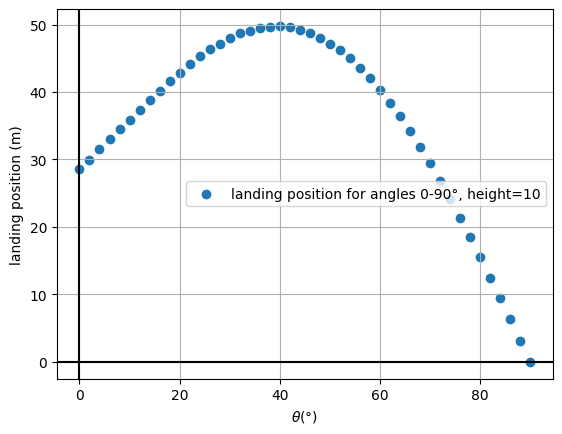

In [4]:
from cannonballsim import landing_position, plot_trajectory_metric

plot_trajectory_metric(
    landing_position,
    range(0, 91, 2),
    plot_label="landing position for angles 0-90°, height=10",
    metric_label="landing position (m)",
    height=10,
    )

Looking at the plot, we can conclude that the angle that maximizes the landing position is around the 40° mark.

We can get the trajectories around that angle and check:

In [7]:
from cannonballsim import trajectory, landing_position

trajectories = {k: landing_position(trajectory(k, height=10)) for k in range(35, 50, 1)}
trajectories

{35: 49.31295306619727,
 36: 49.51184005574664,
 37: 49.675128724941295,
 38: 49.64467747722367,
 39: 49.7373415332459,
 40: 49.79288880273331,
 41: 49.65989037865823,
 42: 49.64207434188969,
 43: 49.439510229456204,
 44: 49.20284234316379,
 45: 49.073210614346316,
 46: 48.765017606221825,
 47: 48.42188356443744,
 48: 48.04357753656617,
 49: 47.62988550471102}

We can see that 40° (and not 45°) is the angle that maximizes the landing position of the projectile when there is an initial height.

## Calculating the optimal range

Using calculus, it is possible to compute the maximum range for the cannon, as well as the angle that produces it.

In order to do so we need:
1. A function that that tells us the range $ r $ as a function of the launch angle $ \theta $, namely $ r(\theta) $.
2. A mechanism to find the maximum value of $ r(\theta) $, and the angle $ \theta $ that produces it. We'll see that the value of $ \theta $ that makes $ r'(\theta) = 0 $, is also the value that yields the maximum value of $ r(\theta) $. We'll see that by studying the graph of $ r(\theta) $ and its changing slope.

### Finding the projectile range as a function of the launch angle

The horizontal distance traveled by the cannonball is not that difficult to calculate.

The $ x $ component of the velocity $ v_x $ remains constant for its entire flight. As a result, for a flight of total time $ \Delta t $, the projectile will travel a total distance of $ v_x \cdot \Delta t $. The complicated part will be to find the exact value of the elapsed time of the flight $ \Delta t $.

That time, $ \Delta t $, depends on the $ z $ position of the projectile over time, namely $ z(t) $.

If the cannonball is launched from an initial height of zero, $ x(0) = 0 $, and the second time at which $ z(t) = 0 $ will be for the $ t = \Delta t $ that we're looking for.

The following figure shows the graph of $ z(t) $ from the simulation with $ \theta = 45° $:

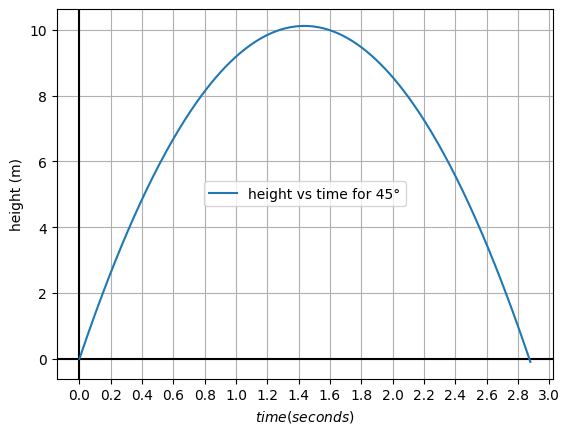

In [17]:
from cannonballsim import trajectory
import matplotlib.pyplot as plt
import numpy as np

trj = trajectory(45)
ts, _, zs, _ = trj

fig, ax = plt.subplots()
ax.grid(True)
ax.set_xticks(np.arange(0, 3.2, 0.2))
ax.set_xlabel(r"$ time (seconds) $")
ax.set_ylabel("height (m)")

ax.axhline(y=0, color="k")
ax.axvline(x=0, color="k")

ax.plot(ts, zs, label="height vs time for 45°")

ax.legend()
plt.show()




We see that the elapsed time falls between 2.8 and 3.0 seconds.

We know that $ z''(t) = -9.81 m/s^2 $, which is the acceleration due to gravity.

We also know that the initial $ z $ (the velocity on the y axis) is $ z'(0) = |\vec{v}| \cdot sin(\theta) $, and the initial z position $ z(0) = 0 $.

Thus, to *recover* the position function $ z(t) $, we need to ingrate the acceleration $ z''(t) $ twice.

The first integral will give us the velocity:

$
\displaystyle
z'(t) = z'(0) + \int_{0}^{t} g \; dt = | \vec{v} | \cdot sin(\theta) + g \cdot t
$

And the second integral will give us the position:
$
\displaystyle
z(t) = z(0) + \int_{0}^{t} z'(t) \; dt = \int_{0}^{t} | \vec{v} | \cdot sin(\theta) + g \cdot t \; dt = | \vec{v} | \cdot sin(\theta) \cdot t + \frac{g}{2} \cdot t^2
$



We can confirm that the function yielded using calculus matches our simulation:

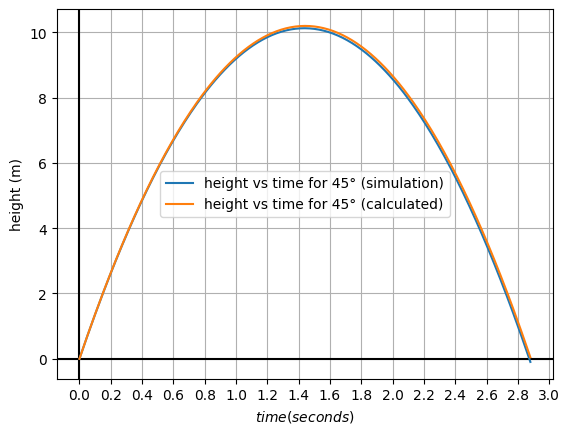

In [19]:
from cannonballsim import trajectory
import matplotlib.pyplot as plt
import numpy as np
from math import sin, pi

def z(t):
    return 20 * sin(45 * pi / 180) * t + (-9.81 / 2) * t ** 2

trj = trajectory(45)
ts, _, zs, _ = trj

fig, ax = plt.subplots()
ax.grid(True)
ax.set_xticks(np.arange(0, 3.2, 0.2))
ax.set_xlabel(r"$ time (seconds) $")
ax.set_ylabel("height (m)")

ax.axhline(y=0, color="k")
ax.axvline(x=0, color="k")

ax.plot(ts, zs, label="height vs time for 45° (simulation)")
ax.plot(ts, [z(t) for t in ts], label="height vs time for 45° (calculated)")


ax.legend()
plt.show()

For notational simplicity, we can write the initial velocity $ | \vec{v} | \cdot sin(\theta) $ as $ v_z $, so that:

$
z(t) = v_z \cdot t + g \cdot \frac{t^2}{2}
$

We want to find the value of $ t $ that makes $ z(t) = 0 $, which is the total hang time for the cannonball.

We know that the value of $ t $ that solves the equation $ a \cdot t^2 + b \cdot t + c = 0 $ is:

$
\displaystyle
t = \frac{-b \pm \sqrt{b^2 - 4ac}}{2a}
$

This is also consistent with our expectation that the equation can be satisfied twice, when our projectile hits $ z = 0 $ (at the initial time and at when the projectile hits the ground).

In the case of solving $ z(t) = v_z \cdot t + g \cdot \frac{t^2}{2} = 0 $, we have $ a = \frac{g}{2} $, $ b = v_z $, and $ c = 0 $.

Plugging it into the formula, we find:

$
t = \frac{-v_z \pm \sqrt{v_{z}^2}}{g} = \frac{-v_z \pm \ v_z}{g}
$

When we treat the $ \pm $ as a +, the result is $ t = 0 $ (as we expected).

When we treat the $ \pm $ as a -, $ t = \frac{-2 \cdot v_z}{g} $.

Let's confirm that the result makes sense.

With an initial speed of 20 m/s and a launch angle of 45°, the initial velocity, $ v_z $ will be:

$
v_z = \frac{-2 \cdot (20 \cdot sin(45°))}{9.81} \\
t \approx 2.88
$

This matches what we saw in our graph (around 2.9 seconds).

This gives us confidence in calculating the hang time as:

$
\Delta t = \frac{-2 \cdot v_z}{g} \\
\Delta t = \frac{-2 \cdot |\vec{v}| \cdot sin(\theta)}{g}
$

We can now plot this side by side with simulated landing positions at various angles and see that it agrees:

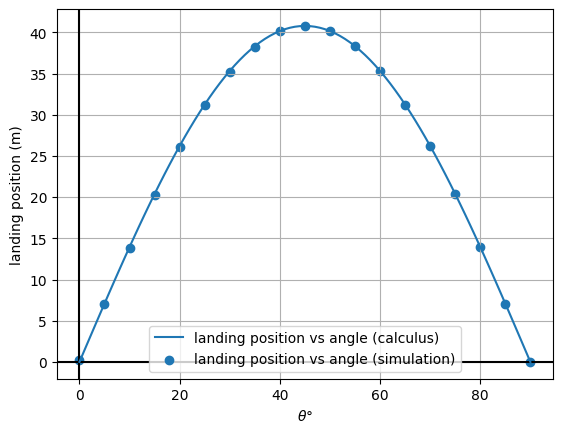

In [26]:
from cannonballsim import trajectory, landing_position
import matplotlib.pyplot as plt
import numpy as np
from math import sin, pi, cos

def r(theta):
    return (-2 * 20 * 20 / -9.81) * sin(theta * pi / 180) * cos(theta * pi / 180)


fig, ax = plt.subplots()
ax.grid(True)
ax.set_xlabel(r"$ \theta °$")
ax.set_ylabel("landing position (m)")

ax.axhline(y=0, color="k")
ax.axvline(x=0, color="k")

ax.plot(range(0, 91), [r(theta) for theta in range(0, 91)], label="landing position vs angle (calculus)")
ax.scatter(range(0, 91, 5), [landing_position(trajectory(theta)) for theta in range(0, 91, 5)], label="landing position vs angle (simulation)")

ax.legend()
plt.show()

Having a function $ r(\theta) $ is a big advantage over repeatedly running the simulator because it tells us the range of the cannon at every launch angle, and not just for a handful of angles we picked. It is also mcuh less computationally expensive as we don't have to run hundreds of iterations of Euler's method.

This function gives us the exact result, rather than an approximation. As a big bonus, we will be able to take the derivative of $ r(\theta) $, which will give us an understanding of how the range of the projectile changes with respect to the launch angle.

### Solving for the maximum range

Let's look at the graph of $ r(\theta) $ to set our expectations with regards to what the derivatived $ r'(\theta) $ will look like.

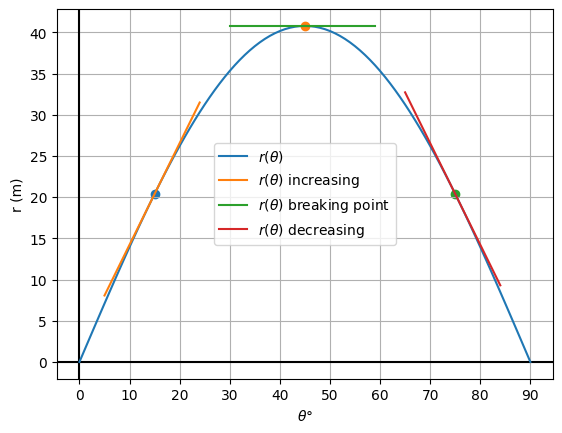

In [15]:
import matplotlib.pyplot as plt
from math import sin, pi, cos
from lines import fn_secant_line

def r(theta):
    return (-2 * 20 * 20 / -9.81) * sin(theta * pi / 180) * cos(theta * pi / 180)


fig, ax = plt.subplots()
ax.grid(True)
ax.set_xlabel(r"$ \theta °$")
ax.set_ylabel("r (m)")
ax.set_xticks(range(0, 91, 10))

ax.axhline(y=0, color="k")
ax.axvline(x=0, color="k")

ax.plot(range(0, 91), [r(theta) for theta in range(0, 91)], label=r"$ r(\theta) $")

secant_line_15 = fn_secant_line(r, 14.99, 15.01)
angles = range(5, 25)
ax.plot(angles, [secant_line_15(angle) for angle in angles], label=r"$ r(\theta) $ increasing")
ax.scatter(15, r(15))

secant_line_45 = fn_secant_line(r, 44.99, 45.01)
angles = range(30, 60)
ax.plot(angles, [secant_line_45(angle) for angle in angles], label=r"$ r(\theta) $ breaking point")
ax.scatter(45, r(45))

secant_line_75 = fn_secant_line(r, 74.99, 75.01)
angles = range(65, 85)
ax.plot(angles, [secant_line_75(angle) for angle in angles], label=r"$ r(\theta) $ decreasing")
ax.scatter(75, r(75))

ax.legend()
plt.show()

We see that as we increase the launch angle from zero, the range increases as well for a while, but at a decreasing rate. Eventually, when going beyond 45°, increasing the launch angle begins to decrease the range.

See that when the derivative $ r(\theta) $ crosses below zero, the range starts decreasing. It is precisely where the derivative $ r'(\theta) $ is zero that the function achieves its maximum value.

We should be able to take the derivative of $ r(\theta) $ symbolically, find where it equals zero in when the angle is between 0° and 90°, and we should get a value close to 45°. 

Thus:

$
\displaystyle
r(\theta) = - \frac{2 \cdot |\vec{v}|^2}{g} \cdot sin(\theta) \cdot cos(\theta)
$

Because $ - \frac{2 \cdot |\vec{v}|^2}{g} $ is a constant, taking the derivative is applying the product rule on $ sin(\theta) \cdot cos(\theta) $:

$
\displaystyle
r'(\theta) = \frac{2 \cdot |\vec{v}|^2}{g} \cdot( cos^2(\theta) - sin^2(\theta))
$


The derivative will be zero when $ ( cos^2(\theta) - sin^2(\theta) ) = 0 $.

And because $ cos(2 \cdot \theta) = cos^2(\theta) - sin^2(\theta) $, we need to find the $ \theta $ such that $ cos(2 \theta) = 0 $.

There are two results to that equation.

First is $ \theta = 45° $, which is the solution we were looking for. The second solution is $ \theta = 135° $ which is consistent with our expectations, as this means shooting the cannoball at 45° but in the opposite direction as seen below.

![Cannonball max range](pics/cannonball_max_range.png)

We can use the $ r(\theta) $ to get the actual maximum range:

In [16]:
def r(theta):
    return (-2 * 20 * 20 / -9.81) * sin(theta * pi / 180) * cos(theta * pi / 180)

print(f"First maximum (0-90)°  : {r(45)}")
print(f"Second maximum (0-135)°: {r(135)}")

First maximum (0-90)°  : 40.77471967380224
Second maximum (0-135)°: -40.77471967380224


### Identifying maxima and minima

To see the difference between the maximum range at 45° and the minimum range at 135° we can plot $ r(\theta) $ over a longer range of $ \theta $.

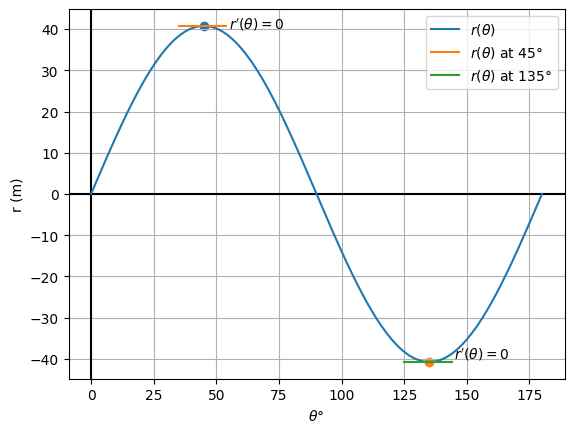

In [8]:
import matplotlib.pyplot as plt
from math import sin, pi, cos
from lines import fn_secant_line

def r(theta):
    return (-2 * 20 * 20 / -9.81) * sin(theta * pi / 180) * cos(theta * pi / 180)


fig, ax = plt.subplots()
ax.grid(True)
ax.set_xlabel(r"$ \theta °$")
ax.set_ylabel("r (m)")
ax.set_xticks(range(0, 181, 25))

ax.axhline(y=0, color="k")
ax.axvline(x=0, color="k")

angles = range(0, 181)
ax.plot(angles, [r(theta) for theta in angles], label=r"$ r(\theta) $")

secant_line_45 = fn_secant_line(r, 44.99, 45.01)
angles = range(35, 55)
ax.plot(angles, [secant_line_45(angle) for angle in angles], label=r"$ r(\theta) $ at 45°")
ax.scatter(45, r(45))

secant_line_135 = fn_secant_line(r, 134.99, 135.01)
angles = range(125, 145)
ax.plot(angles, [secant_line_135(angle) for angle in angles], label=r"$ r(\theta) $ at 135°")
ax.scatter(135, r(135))

# annotations
plt.text(55, 40, r"$ r'(\theta) = 0$")
plt.text(145, -40, r"$ r'(\theta) = 0$")

ax.legend()
plt.show()

We see how the derivative is zero ($ r'(\theta) = 0 $) in those two places.

While maxima (the plural of maximum) of smooth functions occur where the derivative is zero, the converse is not always true; not every place where the derivative is zero yields a maximum value. As we can see in the picture above, it can also yield a minimum value.

You need to be cautious of the global behavior of functions as well, because the derivative can be zero at what's called a local maximum or minimum, where the function briefly obtains a maximum or minimum value, but it's real, overall global maximum or minimum values lie elsewhere.

The following example shows this situation with the function $ y = x^3 - x $:

| NOTE: |
| :---- |
| $ \frac{d}{dx}(x^3 - x) = 3 \cdot x^2 -1 $. |

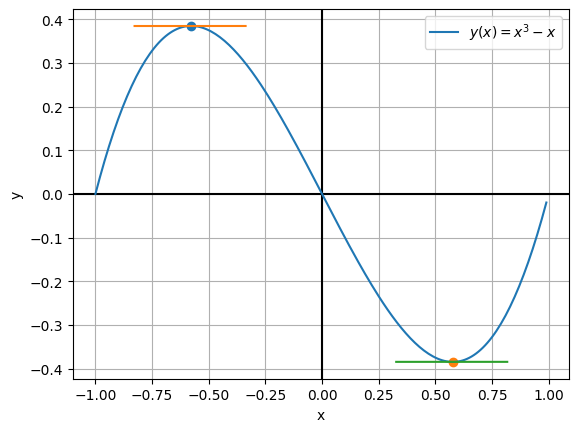

In [14]:
import matplotlib.pyplot as plt
from lines import fn_secant_line
from math import sqrt
import numpy as np

def y(x):
    return x ** 3 - x


fig, ax = plt.subplots()
ax.grid(True)
ax.set_xlabel("x")
ax.set_ylabel("y")

ax.axhline(y=0, color="k")
ax.axvline(x=0, color="k")

xs = np.arange(-1, 1, 0.01)
ax.plot(xs, [y(x) for x in xs], label=r"$ y(x) = x^3 - x $")

secant_line_1 = fn_secant_line(y, -(1 / sqrt(3)) - 0.01, -(1 / sqrt(3)) + 0.01)
xs = np.arange(-(1 / sqrt(3)) - 0.25, -(1 / sqrt(3)) + 0.25, 0.01)
ax.plot(xs, [secant_line_1(x) for x in xs])
ax.scatter(-(1 / sqrt(3)), y(-(1 / sqrt(3))))

secant_line_2 = fn_secant_line(y, (1 / sqrt(3)) - 0.01, (1 / sqrt(3)) + 0.01)
xs = np.arange((1 / sqrt(3)) - 0.25, (1 / sqrt(3)) + 0.25, 0.01)
ax.plot(xs, [secant_line_2(x) for x in xs])
ax.scatter((1 / sqrt(3)), y((1 / sqrt(3))))

ax.legend()
plt.show()

By looking at the graph, we could erroneously think that there are two places that look like maximum and minimum, respectively.

But if we zoom out, we see that neither of these is the maximum or minimum for the whole function as it goes off to infinity in both directions:

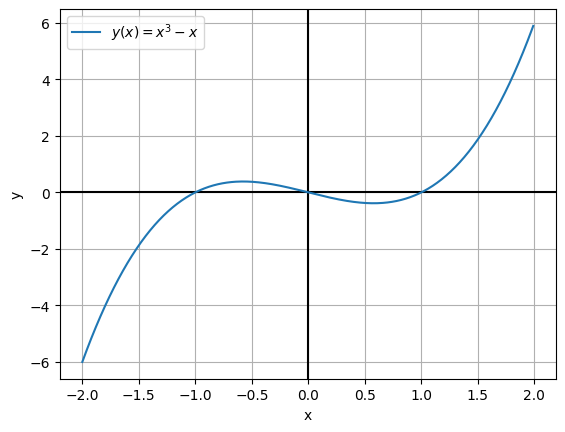

In [16]:
import matplotlib.pyplot as plt
import numpy as np

def y(x):
    return x ** 3 - x


fig, ax = plt.subplots()
ax.grid(True)
ax.set_xlabel("x")
ax.set_ylabel("y")

ax.axhline(y=0, color="k")
ax.axvline(x=0, color="k")

xs = np.arange(-2, 2, 0.01)
ax.plot(xs, [y(x) for x in xs], label=r"$ y(x) = x^3 - x $")

ax.legend()
plt.show()

It might also happen that a point where the derivative is zero is not even a local minimum or maximum.

For example, the function $ y = x^3 $ has a derivative of zero at $ x = 0 $ but that point is neither a maximum or a minimum &mdash; it's just a point where the function stops increasing momentarily:

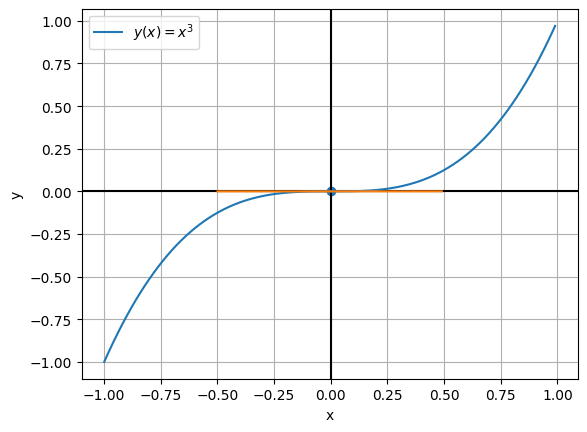

In [20]:
import matplotlib.pyplot as plt
from lines import fn_secant_line
from math import sqrt
import numpy as np

def y(x):
    return x ** 3


fig, ax = plt.subplots()
ax.grid(True)
ax.set_xlabel("x")
ax.set_ylabel("y")

ax.axhline(y=0, color="k")
ax.axvline(x=0, color="k")

xs = np.arange(-1, 1, 0.01)
ax.plot(xs, [y(x) for x in xs], label=r"$ y(x) = x^3 $")

secant_line = fn_secant_line(y,  -0.01, 0.01)
xs = np.arange(-0.50, 0.50, 0.01)
ax.plot(xs, [secant_line(x) for x in xs])
ax.scatter(0, y(0))


ax.legend()
plt.show()

The key idea is that you need to fully understand the behavior of a function before you can confidently say you've found an optimal value &mdash; it's not sufficient to make the derivative of the function equal zero to say you've found a maximum or a minimum.

### Exercises

Use the formula for elapsed time, $ \Delta t $, in terms of the launch angle $ \theta $ to find the angle that maximizes the hang time of the cannonball.